## A PRIMER ON SKYNET




<font size="4">
The phase picker shown here was trained on the CREW datset, which is focused on regional distances, i.e. earthquakes recorded at distances over 100 km from the epicenter. Here you will see the model deployed in settings where seismicity was recorded at hundreds of kilometers away.
</font>

In [1]:
import skynet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime as UT

<font size="4">
Let's see how this earthquake, in the heart of California was recoded in the neighboring state of Nevada
</font>

https://earthquake.usgs.gov/earthquakes/eventpage/ci40685504/executive

<font size="4">

Let's retrieve some waveforms from the Nevada Seismological Network around the origin time of this known earthquake. All of this stations are at distances longer than 100 km from the epicenter.
</font>

In [2]:
reftime = UT('2024-03-11 11:48:40')-100
client  = Client('IRIS')
st      = client.get_waveforms(network='NN',station='*',location='*',channel='HH?',
                       starttime=reftime,endtime=reftime+300)
# apply this check to the stream to ensure the functions that will be called will work properly
st = skynet.sanity_check_stream(st)

<font size="4">
    We need to load a model. This is the default picker, which is set to 'eval' mode by default and picks the first arriving P and S waves.
</font>

In [3]:
model = skynet.load_model('regional_picker')

Regional_Picker(
  (conv1): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,))
  (bn3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(8, 11, kernel_size=(7,), stride=(1,), padding=same)
  (bn4): BatchNorm1d(11, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(11, 11, kernel_size=(7,), stride=(4,), padding=(3,))
  (bn5): BatchNorm1d(11, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(11, 16, kernel_size=(7,), stride=(1,), padding=same)
  (bn6): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(16, 16, kernel_

<font size="4">
The simplest workflow is to use skynet's execute function on a stream of data. This will convert the obspy stream into pytorch tensors which are then fed into the model defined above. Subsequently, the model predictions are used to infer the pick times, based on a set threshold height. The results are written to a csv file, for which we can define the name. By default it will print the name of the saved file and the number of picks. Let's also measure the execution time.
</font>

In [4]:
%%time
outname='lone_pine_event_skynet_picks.csv'
skynet.execute(st,model,outname,threshold=0.5)

Saved results in lone_pine_event_skynet_picks.csv, 46 picks.
CPU times: user 3.27 s, sys: 638 ms, total: 3.91 s
Wall time: 1.07 s


<font size="4">
It took less than one second to execute the cell above, this will scale with the length of the waveforms and the number of stations.
Let's inspect the file containing the picks. Read it with pandas and the columns you should see are network, station, time, score and phase. This is set up for P and S waves.
</font>

In [5]:
picks = pd.read_csv(outname)
picks[:10]

,network,station,time,score,phase
0,NN,S11A,2024-03-11T11:49:22.118300Z,0.908315,P
1,NN,S11A,2024-03-11T11:49:53.018300Z,0.900163,S
2,NN,BFC,2024-03-11T11:49:27.593100Z,0.840782,P
3,NN,BFC,2024-03-11T11:50:04.063100Z,0.878751,S
4,NN,LYSIM,2024-03-11T11:49:31.180000Z,0.708095,P
5,NN,LYSIM,2024-03-11T11:50:52.540000Z,0.627622,P
6,NN,LYSIM,2024-03-11T11:51:17.850000Z,0.600715,S
7,NN,DSP,2024-03-11T11:48:57.028300Z,0.950024,P
8,NN,DSP,2024-03-11T11:49:08.508300Z,0.873674,S
9,NN,PNT,2024-03-11T11:49:28.553100Z,0.775143,P


<font size="4">
Now, let's inspect the waveforms and the picks together, using the $plot\_picks$ function and using st and picks as the input.
</font>

maxlen 30001


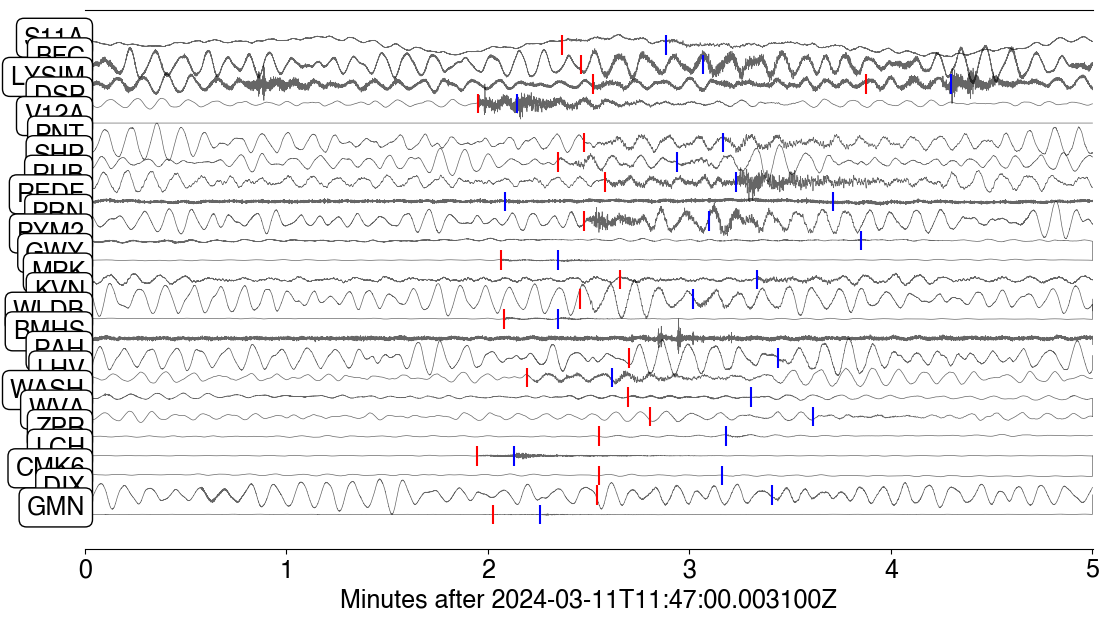

In [6]:
plot=skynet.plot_picks(st,picks)

<font size="4">

This is a messy look. Let's sort the stations based on the time of the first inferred P pick and adjust the size of the figure. This is a crude way to improve the visualization, but for now it helps. Once we have a sorted list of station codes we pass it into $plot\_picks$.
</font>

In [7]:
station_order=picks[picks['phase']=='P'].sort_values(by='time')['station'].to_list()
print(station_order)

['LCH', 'DSP', 'GMN', 'GWY', 'WLDB', 'LHV', 'SHP', 'S11A', 'KVN', 'BFC', 'PNT', 'PRN', 'LYSIM', 'DIX', 'ZPR', 'CMK6', 'RUB', 'MPK', 'WASH', 'PAH', 'WVA', 'LYSIM']


maxlen 30001


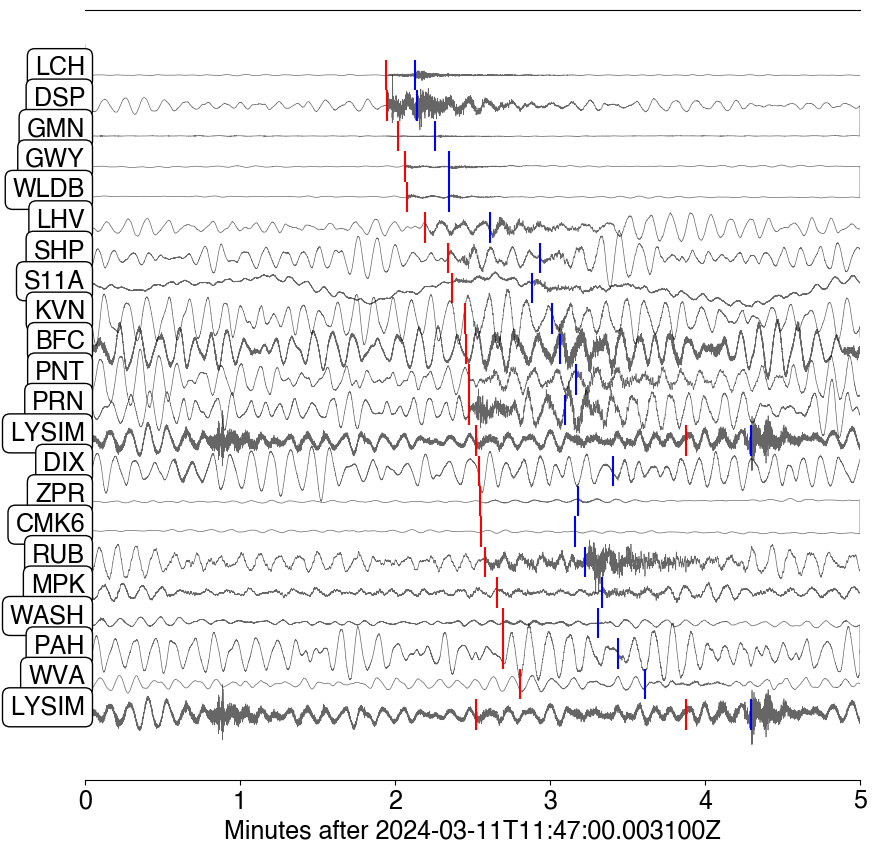

In [8]:
plot=skynet.plot_picks(st,picks,sta_order=station_order,figsize=(10,10))

<font size="4">
Above we have only looked at the inferred picks. If you want to visualize the raw predictions you can do it with plot_skynet_preds
</font>

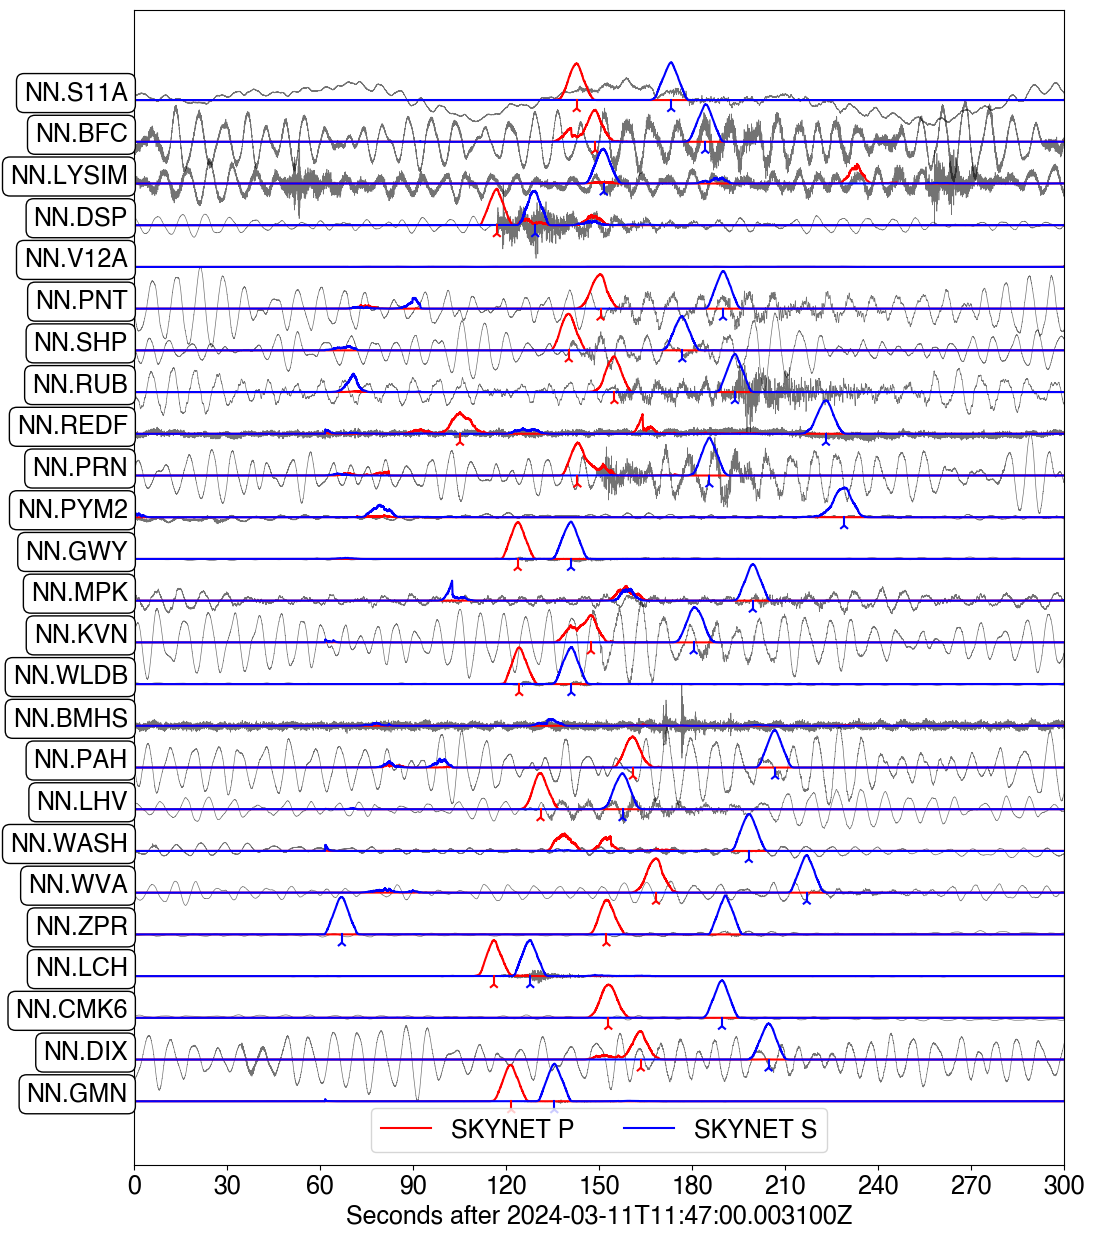

In [9]:
plot=skynet.plot_skynet_preds(st,model,plot_picks=True,figsize=(12,15))

In [10]:
print(st)

75 Trace(s) in Stream:

NN.BFC..HHE | 2024-03-11T11:47:00.003100Z - 2024-03-11T11:52:00.003100Z | 100.0 Hz, 30001 samples
...
(73 other traces)
...
NN.ZPR..HHZ | 2024-03-11T11:46:59.998300Z - 2024-03-11T11:51:59.998300Z | 100.0 Hz, 30001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


<font size="4">
Again, sorting helps visualization. Let's use the same station sorting from above
</font>

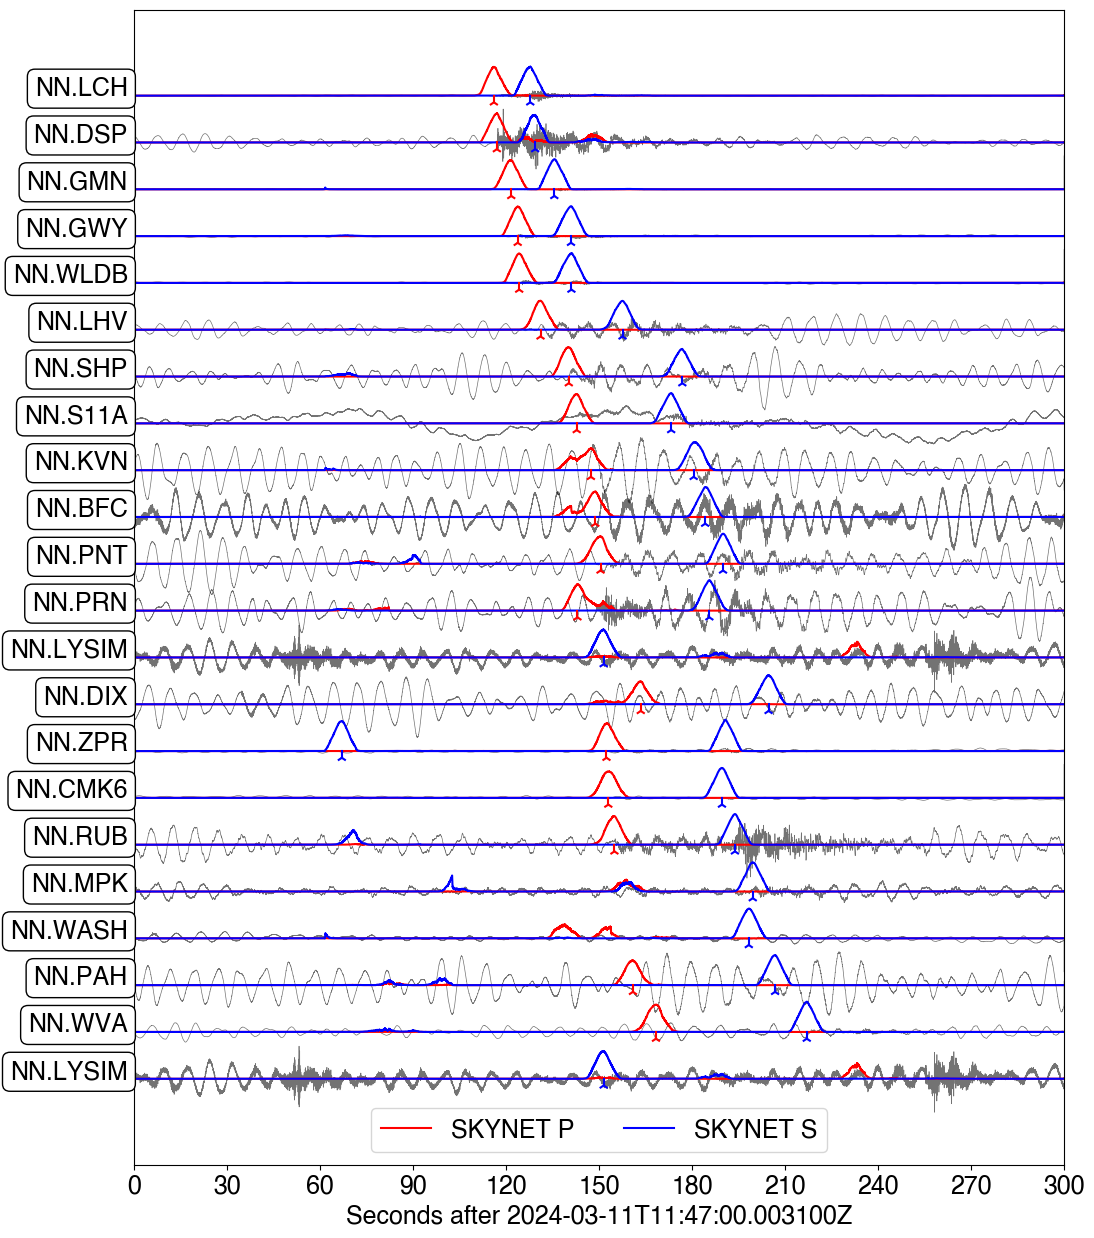

In [11]:
plot=skynet.plot_skynet_preds(st,model,plot_picks=True,figsize=(12,15),v_offset=1.4,sta_order=station_order)

<br>
<br>


<font size="5">
Let's try a longer stream of data. Let's retrieve a little over an hour of data from the CX network in northern Chile and get picks using our regional picker.
</font>

In [12]:
client = Client('GFZ')
reftime = UT('2014-03-16T')+3600
st = client.get_waveforms(network='CX',station='*',location='*',channel='HH?',
                         starttime=reftime,endtime=reftime+3700-0.01)
st = st.merge(fill_value='interpolate')

In [13]:
%%time
outname='cx_skynet_picks.csv'
skynet.execute(st,model,outname,threshold=0.5)

Saved results in cx_skynet_picks.csv, 480 picks.
CPU times: user 9.25 s, sys: 3.69 s, total: 12.9 s
Wall time: 3.4 s


In [14]:
picks=pd.read_csv('cx_skynet_picks.csv')

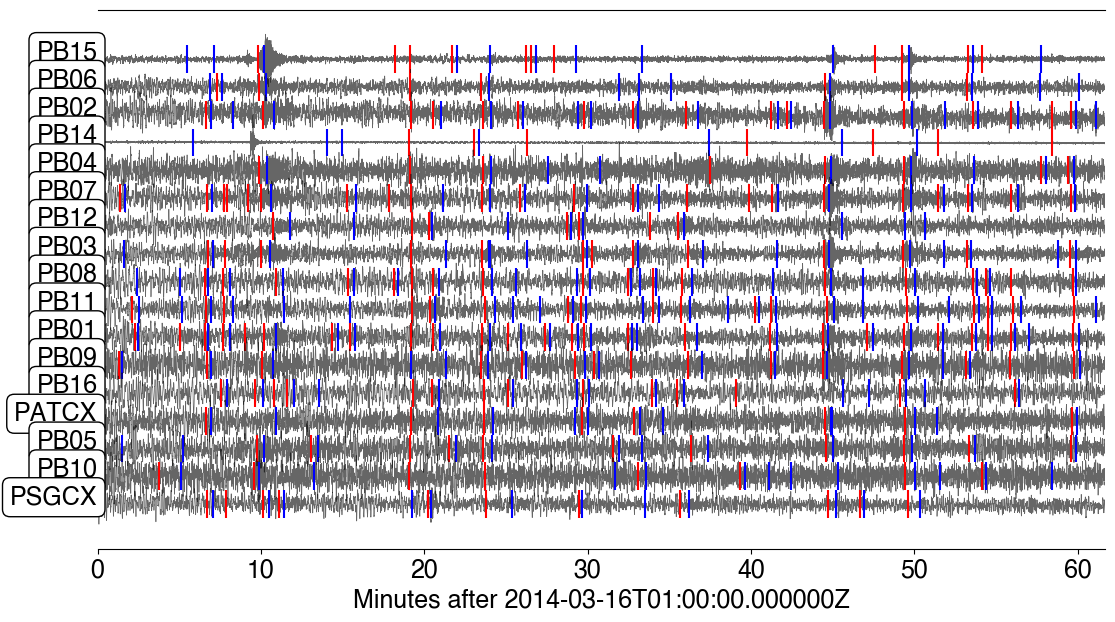

In [15]:
plot=skynet.plot_picks(st,picks)

<font size="4">
The picks are there and are numerous, but very few of the streams have clear earthquake signals. Let's visualize the picks on a filtered version fo the waveforms. Keep in mind that the predictions were done on the raw unfiltered data</font>

In [16]:
f_st = st.copy()
f_st.detrend()
f_st.filter('bandpass',freqmin=1,freqmax=10)
f_st.detrend()

51 Trace(s) in Stream:

CX.PATCX..HHE | 2014-03-16T01:00:00.000000Z - 2014-03-16T02:01:39.990000Z | 100.0 Hz, 370000 samples
...
(49 other traces)
...
CX.PSGCX..HHZ | 2014-03-16T00:59:59.999998Z - 2014-03-16T02:01:39.989998Z | 100.0 Hz, 370000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

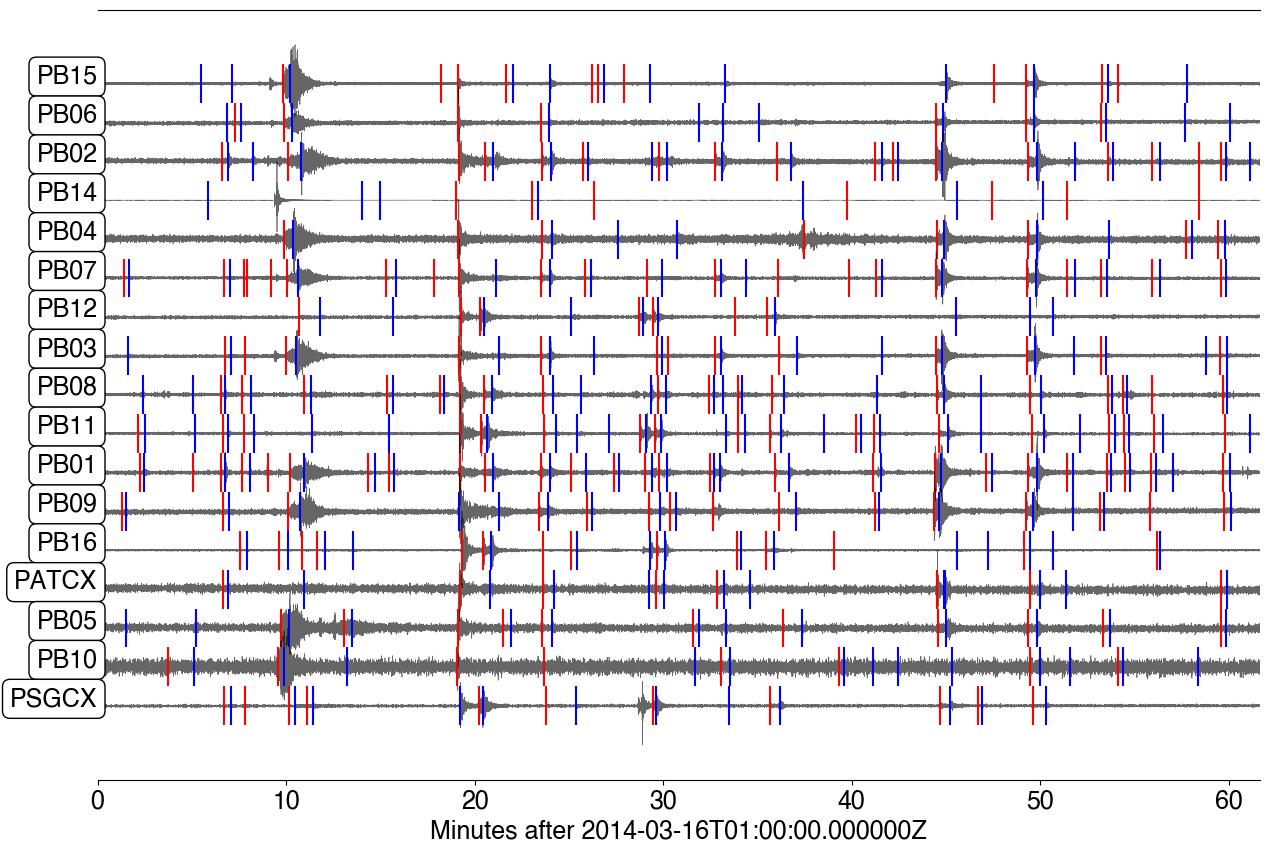

In [17]:
plot=skynet.plot_picks(f_st,picks,figsize=(15,10))

<br>
<br>

<font size="5">
Now, we have our phase picks. The next step to build a catalog of events is to associate these phase picks. For that we refer you to tools like GENIE, PyOcto or GAMMA
</font>